In [1]:
import parse_data.preprocess as preprocess
import parse_data.loading as loading
from analysis.response_times import calculate_response_times, plot_response_times
import data_extraction.get_indices as get_indices
import globals
from plotting import plot_octagon, plot_trajectory
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import Polygon
from matplotlib import colors
import math

In [2]:
# paths
data_folder = '/home/tom/Documents/SWC/data' # desktop Duan Lab
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-53-34_YansuSecondSolo.json' 
json_filename = '240913_Yansu_Jerry/2024-09-13_11-31-00_YansuJerrySocial.json'
# data_folder = r'D:\Users\Tom\OneDrive\PhD\SWC\data' # desktop home
# json_filename = r'first_experiments_2409\240913\2024-09-13_11-23-37_YansuFirstSolo.json'
# json_filename = r'first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json'


In [3]:
# Load JSON file into pandas df with collapsed data dictionary and adjustments based on date of recording 
df = loading.loading_pipeline(data_folder, json_filename)

Data is from period before 2024-09-13 11:31:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.


In [4]:
# Pre-process data 
df = preprocess.standard_preprocessing(df)

Preprocessing complete.


In [5]:
## Extract single trials ##

In [6]:
def split_session_by_trial(df):
    
    # groupby produces an interable of tuples with the group key and the dataframe 
    trials_list = [data for _, data in df.groupby('data.trialNum')]
    
    # exclude trial 0 (could also exclude trial 1)
    trials_list = trials_list[1:]

    # if final  trial does not contain a server selected trigger activation, discard it
    if not globals.SELECTED_TRIGGER_ACTIVATION in trials_list[-1]['eventDescription'].unique():
        trials_list = trials_list[:-1]

    return trials_list


In [7]:
trial_list = split_session_by_trial(df)

In [8]:
## HEATMAPS ##

In [32]:
# generate the location data

n_rows = 6
n_cols = 6
x_min, x_max = -20, 20
y_min, y_max = -20, 20
grid_width = (x_max - x_min)/n_cols
grid_height = (y_max - y_min)/n_rows

# define heatmap meshgrid
x = np.linspace(x_min, x_max, n_cols)
y = np.linspace(x_min, x_max, n_rows)
grid = np.zeros([n_rows, n_cols])

# extract starting location of winner for each trial
trigger_activators_trial_start_loc = get_indices.get_trigger_activators_trial_start_loc(trial_list)
trigger_activators_trial_start_loc = np.asarray(trigger_activators_trial_start_loc)

# Create a matrix of heatmap counts based on which bin starting location fits into
for i in range(len(trigger_activators_trial_start_loc[:,0])):
    x_val = trigger_activators_trial_start_loc[i,0]
    y_val = trigger_activators_trial_start_loc[i,1]
    x_bin = int((x_val - x_min)/grid_width)
    y_bin = int((y_val - y_min)/grid_height)

    if 0 <= y_bin < n_rows and 0 <= x_bin < n_cols:
            grid[y_bin, x_bin] += 1
    



In [28]:
trigger_activators_trial_start_loc[:,0]

array([ -0.69918722,   5.65413809,  13.66923904,  -5.35624981,
        -1.1439364 ,  -1.79552734,   2.53497744,  -0.72250128,
        -3.58899617,  -1.10651016,  -4.84858131,   5.51324654,
        -2.92702651,  -5.01747179,   0.83832163,  -1.59952343,
       -13.35257912,   3.48184228,   0.05267506,   7.8498559 ,
        -3.63484025,   7.97480249,   7.57786989,   9.20009804,
        -1.3260175 ,  -8.79484081, -15.26456642,   1.5714227 ,
        14.31084538,  12.26707268,  -4.11557102,  11.8354044 ,
        -2.27736259,  -5.00645876,   7.84214258,  -2.68627262,
        -1.95458996,  -1.43287349,  -1.2511884 ,   4.03837204,
        -3.19962454, -13.96337605, -11.44855118,  -4.32443047,
        -3.17955709,   0.75512105,  -2.25580907,   8.78391838,
         0.55039465,   1.15510488,  -0.94872701,   1.53657222,
         4.41180992,  -6.68701124,  -1.13031065,  -2.24562359,
         1.59376383,   2.59180546,   0.45551625,  -8.37679291,
         4.21912098,  -1.97720182,   7.79388237,  -4.70

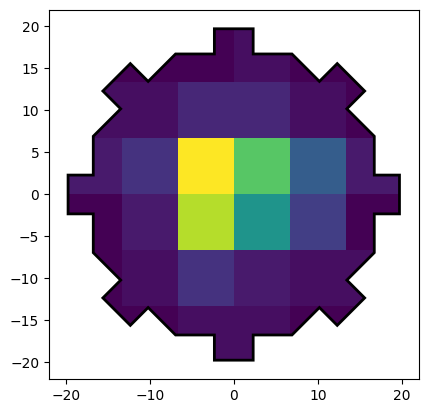

In [38]:
# get the zipped coordinate list of octagon x and y vertex points
octagon_vertex_coordinates = plot_octagon.return_octagon_path_points()

# create a matplotlib Path object from them
octagon_path = Path(octagon_vertex_coordinates)

# # create example heatmap for now (gaussian)
# Z = np.exp(-(X**2 + Y**2))
# use heatmap data

# flatten my meshgrid (?)
points = np.vstack((X.ravel(), Y.ravel())).T

polygon = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)


# # Display the heatmap, with NaN values resulting in transparent (masked) regions
# im = plt.gca().imshow(Z, extent=[x.min(), x.max(), y.min(), y.max()],
#            origin='lower', cmap='viridis')


# Display the heatmap, with NaN values resulting in transparent (masked) regions
im = plt.gca().imshow(grid, extent=[x.min(), x.max(), y.min(), y.max()],
           origin='lower', cmap='viridis')

patch = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)
ax = plt.gca()

ax.add_patch(patch)
im.set_clip_path(patch)

# Set aspect ratio to ensure the shape looks correct
ax.set_aspect(1.)

# plt.colorbar()

ax.set_xlim([-22,22])
ax.set_ylim([-22,22])

# Show the plot
plt.show()

In [ ]:
octagon_vertex_coordinates

In [ ]:
plt.plot(octagon_vertex_coordinates)

In [ ]:
x_coords, y_coords = zip(*octagon_vertex_coordinates)

In [ ]:
plt.plot(x_coords, y_coords)
plt.gca().set_aspect(1.)